In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached https://files.pythonhosted.org/packages/a8/eb/a48f25c967526b66d5f1fa7a984594f0bf0a5afafa94a8c4dbc317744620/scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl


<h2>Load csv into dataframe</h2>

In [ ]:
#Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

<h2>Get previous stats into the dataframe</h2>

In [ ]:
#Use the GamesClean.csv made from the NeuralNetClean #2.rmd from Neural Network and Text Analysis Folder
df = pd.read_csv(r'/content/GamesClean.csv')

# Need this so that we don't get an error for empty columns.
combined_df = pd.DataFrame(columns = [""] * 26) 

for team in pd.unique(df["Team"]):
  # Get previous columns
  prev = df.loc[df["Team"] == team]
  # Rename the previous columns with a prev
  columns = list(prev) 
  for i in range(len(columns)):
    columns[i] = "prev_" + columns[i]
  prev.columns = columns

  # Add place holders. Prev gets one at the end and cur gets one at the start.
  # This is done so prev is actually the previous values.
  prev = prev.append(pd.DataFrame([prev.iloc[0]]))
  cur = df.loc[df["Team"] == team]
  cur = pd.DataFrame([cur.iloc[0]]).append(cur)              

  cur.reset_index(drop=True, inplace=True)
  prev.reset_index(drop=True, inplace=True)

  # Combine the dataframes
  combined = pd.concat([cur, prev], axis = 1, ignore_index = True)
  combined_cols = list(cur.columns)
  combined_cols.extend(list(prev.columns))
  combined.columns = combined_cols

  # Drop first and last rows
  combined = combined.drop(combined.index[[0]])
  combined = combined.drop(combined.index[[-1]])

  combined_df.columns = combined.columns
  combined_df = combined_df.append(combined)

<h2>Add month / year / team id</h2>

In [ ]:
import psycopg2

db_login = {
    'database': 'basketball',
    'user': 'globetrotter',
    'password': 'alpacaalpaca',
    'host': 'blaskey.dev',
    'port': 5432
}
conn = psycopg2.connect(**db_login)
cur = conn.cursor()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# Get list of team names and ids
conn.rollback()
cur.execute("SELECT team_id, nickname FROM team")
team_to_id = {}
for i in cur.fetchall():
  team_to_id[i[1]] = i[0]
print(team_to_id)

{'Hawks': 1610612737, 'Celtics': 1610612738, 'Bulls': 1610612741, 'Mavericks': 1610612742, 'Nuggets': 1610612743, 'Rockets': 1610612745, 'Clippers': 1610612746, 'Lakers': 1610612747, 'Heat': 1610612748, 'Bucks': 1610612749, 'Timberwolves': 1610612750, 'Knicks': 1610612752, 'Pacers': 1610612754, 'Trail Blazers': 1610612757, 'Kings': 1610612758, 'Spurs': 1610612759, 'Thunder': 1610612760, 'Raptors': 1610612761, 'Jazz': 1610612762, 'Grizzlies': 1610612763, 'Wizards': 1610612764, 'Pistons': 1610612765, 'Hornets': 1610612766, 'Cavaliers': 1610612739, 'Warriors': 1610612744, 'Pelicans': 1610612740, '76ers': 1610612755, 'Suns': 1610612756, 'Magic': 1610612753, 'Nets': 1610612751}


In [ ]:
combined_df["Month"] = combined_df["Date"].apply(lambda x: int(x.split("/")[0]))
combined_df["Year"] = combined_df["Date"].apply(lambda x: int(x.split("/")[2]))  
combined_df["Team_id"] = combined_df["Team"].apply(lambda x: team_to_id[x])  

In [ ]:
combined_df

,Unnamed: 0,Date,Team,Points,FG_PCT,FT_PCT,FG3_PCT,Assists,Rebounds,Positivity,Tweet,Home,Win,prev_Unnamed: 0,prev_Date,prev_Team,prev_Points,prev_FG_PCT,prev_FT_PCT,prev_FG3_PCT,prev_Assists,prev_Rebounds,prev_Positivity,prev_Tweet,prev_Home,prev_Win,Month,Year,Team_id
1,33460,10/7/2003,76ers,79,0.329,0.897,0.143,7,44,0.0,0,0,0,33433,10/28/2003,76ers,89,0.440,0.533,0.350,25,39,0.0,0,1,1,10,2003,1610612755
2,33433,10/28/2003,76ers,89,0.440,0.533,0.350,25,39,0.0,0,1,1,33394,10/31/2003,76ers,89,0.418,0.767,0.000,16,40,0.0,0,0,0,10,2003,1610612755
3,33394,10/31/2003,76ers,89,0.418,0.767,0.000,16,40,0.0,0,0,0,33376,11/1/2003,76ers,90,0.468,0.545,0.526,22,25,0.0,0,0,0,10,2003,1610612755
4,33376,11/1/2003,76ers,90,0.468,0.545,0.526,22,25,0.0,0,0,0,33352,11/3/2003,76ers,94,0.485,0.771,0.250,19,29,0.0,0,0,1,11,2003,1610612755
5,33352,11/3/2003,76ers,94,0.485,0.771,0.250,19,29,0.0,0,0,1,33333,11/5/2003,76ers,99,0.407,0.833,0.235,25,44,0.0,0,1,0,11,2003,1610612755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,301,3/12/2021,Wizards,101,0.488,0.591,0.333,19,32,0.0,0,1,0,137,3/13/2021,Wizards,119,0.457,0.773,0.390,25,41,0.0,0,1,0,3,2021,1610612764
1579,137,3/13/2021,Wizards,119,0.457,0.773,0.390,25,41,0.0,0,1,0,99,3/15/2021,Wizards,122,0.506,0.750,0.421,34,33,0.0,0,1,0,3,2021,1610612764
1580,99,3/15/2021,Wizards,122,0.506,0.750,0.421,34,33,0.0,0,1,0,69,3/17/2021,Wizards,119,0.489,0.821,0.160,25,52,0.0,0,1,0,3,2021,1610612764
1581,69,3/17/2021,Wizards,119,0.489,0.821,0.160,25,52,0.0,0,1,0,51,3/18/2021,Wizards,131,0.547,0.789,0.412,23,43,0.0,0,1,1,3,2021,1610612764


<h2>Make X and y columns</h2>

In [ ]:
#Making a list of all predictors and response variable. The predictors include the month, year, 
#team ID, whether it is a home game, if there was previous tweet and the postivity of the tweet.
#The predictors also contains values from the previous game such as that games point, field goal percentage 
#field throw percentage, 3 point field goal percentage, assists, rebound and outcome.
#The response variable is whether the game will be won.
X = combined_df[["Month", "Year", "Team_id", "prev_Points", "prev_FG_PCT",
                 "prev_FT_PCT", "prev_FG3_PCT", "prev_Assists", 
                 "prev_Rebounds",  "Home", 
                 "Positivity", "Tweet", "prev_Win"]].to_numpy()
y = combined_df["Win"].to_numpy()

print(X, X.shape)
print(y.shape, y)

[[10 2003 1610612755 ... 0.0 0 1]
 [10 2003 1610612755 ... 0.0 0 0]
 [10 2003 1610612755 ... 0.0 0 0]
 ...
 [3 2021 1610612764 ... 0.0 0 0]
 [3 2021 1610612764 ... 0.0 0 1]
 [3 2021 1610612764 ... 0.0 0 0]] (48187, 13)
(48187,) [0 1 0 ... 0 0 1]


In [ ]:
class Preprocess: 
  def __init__(self, oneHot, minMax):
    self.OneHotEncoder = oneHot
    self.MinMaxScaler = minMax

  def fit(self, data):
    self.OneHotEncoder.fit(data[::, 2].reshape(len(data), 1))
    self.MinMaxScaler.fit(np.concatenate([data[::, 0:3], data[::, 3:9]], axis = 1))

  def transform(self, data):
    oneHoted = self.OneHotEncoder.transform(
        data[::, 2].reshape(len(data), 1))
    minMaxed = self.MinMaxScaler.transform(
        np.concatenate([data[::, 0:3], data[::, 3:9]], axis = 1)
    )
    return np.concatenate([minMaxed, oneHoted, data[::, 9:]], axis = 1)

In [ ]:
preprocess = Preprocess(OneHotEncoder(sparse=False), MinMaxScaler())
preprocess.fit(X)
X_transformed = preprocess.transform(X)
print(X_transformed.shape)

(48187, 43)


In [ ]:
X_transformed[1]

array([0.8181818181818182, 0.0, 0.6206896528601646, 0.41481481481481486,
       0.3954545454545454, 0.7281213535589265, 0.0, 0.27906976744186046,
       0.3787878787878788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0, 0], dtype=object)

In [ ]:
X_transformed=np.asarray(X_transformed).astype('float32')
y=np.asarray(y).astype('float32')

In [ ]:
X_transformed[1]

array([0.8181818 , 0.        , 0.62068963, 0.4148148 , 0.39545456,
       0.72812134, 0.        , 0.27906978, 0.37878788, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

<h2>Nerual Network</h2>

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_transformed,y,test_size=0.2)

In [ ]:
import tensorflow as TF
#Creating Layers
kerasmodels=TF.keras.Sequential()
kerasmodels.add(TF.keras.layers.Dense(43))
kerasmodels.add(TF.keras.layers.Dropout(0.2))
kerasmodels.add(TF.keras.layers.Dense(86,activation='tanh'))
kerasmodels.add(TF.keras.layers.Dense(43,activation='tanh'))
kerasmodels.add(TF.keras.layers.Dense(22,activation='tanh'))
kerasmodels.add(TF.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
#Compling data
kerasmodels.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Training and testing data
ModelHis=kerasmodels.fit(x_train,y_train,epochs=90)

Epoch 1/90
1205/1205 [==============================] - 2s 1ms/step - loss: 0.6763 - accuracy: 0.5820
Epoch 2/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6686 - accuracy: 0.5977
Epoch 3/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6636 - accuracy: 0.6012
Epoch 4/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6656 - accuracy: 0.5974
Epoch 5/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6607 - accuracy: 0.6031
Epoch 6/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6627 - accuracy: 0.6037
Epoch 7/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6620 - accuracy: 0.6045
Epoch 8/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6607 - accuracy: 0.6048
Epoch 9/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.6572 - accuracy: 0.6130
Epoch 10/90
1205/1205 [==============================] - 1s 1ms/step - loss: 0.656

In [ ]:
print(ModelHis.history.keys())

dict_keys(['loss', 'accuracy'])


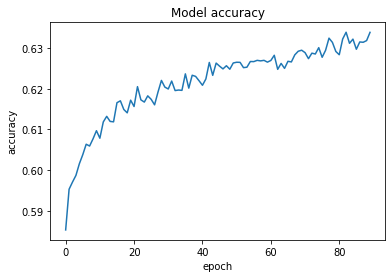

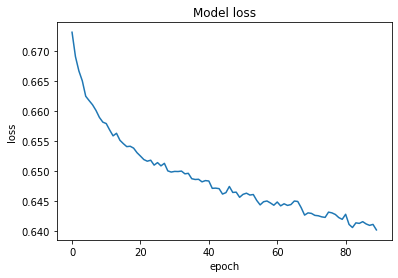

In [ ]:
import matplotlib.pyplot as mpl
mpl.plot(ModelHis.history['accuracy'])
mpl.ylabel('accuracy')
mpl.xlabel('epoch')
mpl.title('Model accuracy')
mpl.show()
mpl.plot(ModelHis.history['loss'])
mpl.ylabel('loss')
mpl.xlabel('epoch')
mpl.title('Model loss')
mpl.show()

In [ ]:
values, accuracy=kerasmodels.evaluate(x_test,y_test)
print(values, accuracy)

302/302 [==============================] - 0s 749us/step - loss: 0.6590 - accuracy: 0.6086
0.658993124961853 0.608632504940033


In [ ]:
prob_preds = kerasmodels.predict(x_test)
prob_preds # Checking if the probablities are different

array([[0.38204846],
       [0.410938  ],
       [0.68559015],
       ...,
       [0.38766968],
       [0.40923584],
       [0.48738104]], dtype=float32)

In [ ]:
print(np.sum(y_train))
print(np.sum(x_train))
print(np.sum(y_test))
print(np.sum(x_test))

19322.0
246324.58
4778.0
61546.207


In [ ]:
kerasmodels.save("nerualnet.h5")

<h2>Save preprocessor</h2>


In [ ]:
import pickle 
filehandler = open("OneHotEncoder.pkl", 'wb') 
pickle.dump(preprocess.OneHotEncoder, filehandler)
filehandler.close()

filehandler = open("MinMaxScaler.pkl", 'wb') 
pickle.dump(preprocess.MinMaxScaler, filehandler)
filehandler.close()

